### Import packages

In [1]:
import cv2
import skimage
from matplotlib import pyplot as plt
import numpy as np
import time
import pandas as pd

plt.style.use("default")

import cvxpy as cp
from math import pi,sin,cos,sqrt

### Helper methods 

In [2]:
def get_warp(
    img_path,
    size = None,    # (dd, n)
    save_warp = False,
    show_warp = False,
):
    """
    Remaps image to polar coordinates space
    """
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)/255.0
    h, w = image.shape

    if size == None:
        dd, n = h,w
    else:
        dd, n = size

    image_polar = cv2.warpPolar(
        image, 
        center=(w/2, h/2), 
        maxRadius=min(w,h)/2, 
        dsize=(n,dd), 
        flags=cv2.INTER_LINEAR + cv2.WARP_FILL_OUTLIERS)
    
    if save_warp:
        target_path = f"{time.strftime('%Y-%m-%d-%H%M%S')}.png"
        cv2.imwrite(target_path, image_polar*255.0)
    if show_warp:
        plt.imshow(image_polar, cmap="gray")
    
    return image_polar

def create_dft_matrix(n):
    """
    Discrete Fourier Transform Matrix
    """
    W = np.zeros((2*n+1,2*n+1)).astype(complex)
    for i in range(2*n+1):
        for j in range(2*n+1):
            ii = i - n
            arg = ii * j * (2 * pi) / (2*n+1)
            W[i,j] = cos(arg) + 1j * sin(arg)
    W = W / sqrt(2*n+1)
    return W

### Get image

- `REF_PATH`: path to image to be used as reference
- `OBS_PATH`: path to image to be transformed and align to reference
- `DD`, `N`: dimensions for convex program
    - required to be an odd positive integer less than input images
    - higher value provides better solution, but longer to solve the convex program

In [3]:
REF_PATH = 'mona_lisa_ref.png'
OBS_PATH = 'mona_lisa_obs.png'

DD, N = 101, 101

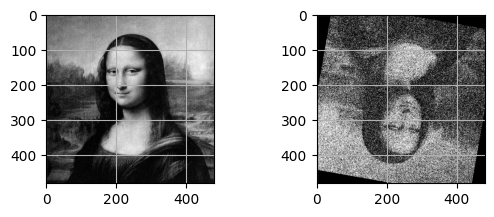

In [4]:
"""
View input images
"""

fig = plt.figure()
for idx, path in enumerate([REF_PATH, OBS_PATH]):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    _ = fig.add_subplot(2,2,idx+1)
    _.imshow(img, cmap="gray")
    plt.grid()

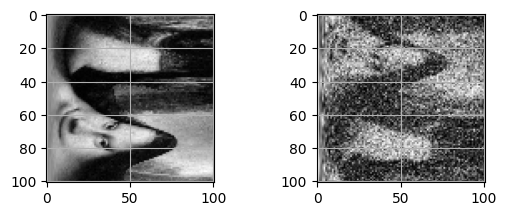

In [5]:
"""
Map images to polar coordinates
"""

ref_mat = get_warp(REF_PATH, (DD, N))
obs_mat = get_warp(OBS_PATH, (DD, N))

fig = plt.figure()
for idx, img in enumerate([ref_mat, obs_mat]):
    _ = fig.add_subplot(2,2,idx+1)
    _.imshow(img, cmap="gray")
    plt.grid()

### Solve the following optimization instance
$\begin{align*}
\max \quad &\sum_{j=1}^N \langle \phi_{j, ref} \circ \phi_{j,obs}^\dag, x \rangle + \langle x, \phi_{j, ref} \circ \phi_{j,obs}^\dag \rangle \\
\text{s.t.} \quad & x=X[:,0] \\
& X \text{ is PSD, Toeplitz} \\
& X[i,i] = 1
\end{align*}$

In [6]:
d = int((DD-1)/2)
dft = create_dft_matrix(d)  # DFT matrix
inv_dft = np.linalg.inv(dft)  # inverse DFT matrix

In [7]:
# Input data
phi_ref = (dft @ ref_mat)[d:,]
phi_obs = (dft @ obs_mat)[d:,]

# Variables
X_mat = cp.Variable((d+1,d+1), hermitian=True)

objective = cp.Maximize(cp.real(cp.sum(
    cp.matmul(cp.conj(cp.diag(X_mat[:,0])), cp.multiply(phi_ref, cp.conj(phi_obs)))
    + cp.matmul(cp.diag(X_mat[:,0]), cp.conj(cp.multiply(phi_ref, cp.conj(phi_obs))))
)))

# Constraints
constraints  = [X_mat >> 0]                                                         # PSD
constraints += [X_mat[i,j] == X_mat[i+1,j+1] for i in range(d) for j in range(d)]   # Toeplitz <-- to vectorize?
constraints += [X_mat[0,0] == 1]

# Setup problem
prob = cp.Problem(objective, constraints)

In [8]:
start_time = time.time()
prob.solve()
time_elapsed = time.time() - start_time

print("[Solver: {} | Status: {}] \nOpt Val: {} [{:.3f}s]".format(prob.solver_stats.solver_name, prob.status, prob.value, time_elapsed))

[Solver: SCS | Status: optimal] 
Opt Val: 3533.375341617581 [12.993s]


### Transform observed image to align with reference image

In [9]:
"""
Recover top half of the matrix phi_obs which was truncated
"""

phi_opt = cp.matmul(cp.diag(X_mat[:,0]), phi_obs)

truncated_top = np.flip(phi_opt.value[1:,].conj(), axis=0)
original_phi_opt = np.concatenate([truncated_top, phi_opt.value])

recovered_phi = np.real(inv_dft @ original_phi_opt)
# plt.imshow(recovered_phi, cmap="gray")

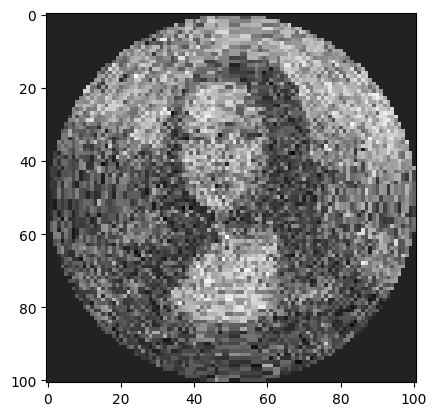

In [10]:
"""
Inverse mapping back from polar coordinates
"""

recovered_img = cv2.warpPolar(
    recovered_phi, 
    center=(DD/2, N/2), 
    maxRadius=min(DD,N)/2, 
    dsize=(DD,N), 
    flags=cv2.INTER_NEAREST + cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)

plt.imshow(recovered_img, cmap="gray")
# skimage.io.imsave(f"images/output/{time.strftime('%Y-%m-%d-%H%M%S')}.png", skimage.util.img_as_ubyte(recovered_img))